---
title: "Instrumental variable analysis and Mendelian randomization"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Instrumental variable analysis is one method for causal inference. This approach relies on deconfounding an explanatory variable $X$ by using an exogenous variable ($Z$, the instrument) for the outcome $Y$. Here I wanted to have a better understanding of instrumental variable analysis as a path to applying it to Mendelian randomization, especially when my outcome is a disease, a binary outcome.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit
from utils import draw_causal_graph, standardize

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
sns.set_context("talk")
sns.set_palette("colorblind")

# McElreath's wages and education example

## Model 14.6

Re-do the Statistical Rethinking example model 14.6 first. Here I reference [pymc translation](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb) of R code 14.26.

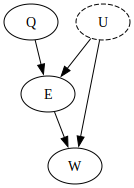

In [3]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("U", "E"), ("U", "W"), ("E", "W")],
    node_props={"U": {"style": "dashed"}},
    graph_direction="TD",
)

$$ \left( \begin{array}{c} W_i \\ {E_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{W_i}}  \\ {\mu_{E_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{W_i} = \alpha_W + \beta_{EW} W_i  $$
$$ \mu_{E_i} = \alpha_E + \beta_{QE} E_i  $$
$$ \alpha_W, \alpha_E \sim \text{Normal}(0, 1.5) $$
$$ \beta_{EW}, \beta_{QE} \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{W}^2 & \rho\sigma_{W}\sigma_{E} \\ 
                \rho\sigma_{W}\sigma_{E} & \sigma_{E}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{W} & 0 \\ 0 & \sigma_{E} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$

In [18]:
N = 500
U_sim = np.random.normal(size=N)
Q_sim = np.random.randint(1, 5, N)
E_sim = np.random.normal(loc=U_sim + Q_sim, size=N)
W_sim = np.random.normal(loc=U_sim + 0 * E_sim, size=N)
dat_sim = pd.DataFrame.from_dict(
    {"W": standardize(W_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
)
dat_sim.head()

,W,E,Q
0,0.361023,0.082998,-0.449745
1,1.860768,1.806510,0.432108
2,-0.026842,-0.758278,-0.449745
3,0.344664,0.875179,1.313962
4,0.300556,0.445355,0.432108


In [5]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

with pm.Model() as m14_6:
    aW = pm.Normal("aW", 0.0, 0.2)
    aE = pm.Normal("aE", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQE = pm.Normal("bQE", 0.0, 0.5)

    muW = aW + bEW * dat_sim.E.values
    muE = aE + bQE * dat_sim.Q.values
    chol, _, _ = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    WE_obs = pm.Data("WE_obs", dat_sim[["W", "E"]].values, mutable=True)
    WE = pm.MvNormal("WE", mu=pt.stack([muW, muE]).T, chol=chol, observed=WE_obs)

    trace_14_6 = pm.sample(1000, random_seed=RANDOM_SEED)
    trace_14_6.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)

az.summary(trace_14_6, var_names=["aW", "aE", "bEW", "bQE", "Rho", "Sigma"], round_to=2)

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,-0.00,0.04,-0.08,0.08,0.0,0.0,3646.51,3201.67,1.0
aE,-0.00,0.04,-0.07,0.07,0.0,0.0,3570.85,2902.29,1.0
bEW,0.05,0.07,-0.08,0.18,0.0,0.0,2074.85,2315.11,1.0
bQE,0.61,0.04,0.54,0.68,0.0,0.0,3100.79,2793.09,1.0
"Rho[0, 0]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,NaN
"Rho[0, 1]",0.51,0.05,0.41,0.60,0.0,0.0,2050.32,2296.54,1.0
"Rho[1, 0]",0.51,0.05,0.41,0.60,0.0,0.0,2050.32,2296.54,1.0
"Rho[1, 1]",1.00,0.00,1.00,1.00,0.0,0.0,3707.94,3633.85,1.0
Sigma[0],0.98,0.04,0.90,1.06,0.0,0.0,2211.47,2300.57,1.0
Sigma[1],0.79,0.02,0.75,0.84,0.0,0.0,5515.36,3411.95,1.0


Above values approximate McElreath's R code examples.

## Can you recover the proper coefficients if the outcome is binary?

Create a new variable R (rich or not) that is the result of increased wages.

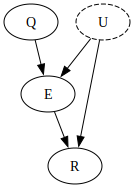

In [6]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("U", "E"), ("U", "R"), ("E", "R")],
    node_props={"U": {"style": "dashed"}},
    graph_direction="TD",
)

$$ R_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = W_i $$
$$ \left( \begin{array}{c} W_i \\ {E_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{W_i}}  \\ {\mu_{E_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{W_i} = \alpha_W + \beta_{EW} W_i  $$
$$ \mu_{E_i} = \alpha_E + \beta_{QE} E_i  $$
$$ \alpha_W, \alpha_E \sim \text{Normal}(0, 1.5) $$
$$ \beta_{EW}, \beta_{QE} \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{W}^2 & \rho\sigma_{W}\sigma_{E} \\ 
                \rho\sigma_{W}\sigma_{E} & \sigma_{E}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{W} & 0 \\ 0 & \sigma_{E} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$

In [19]:
index_val = dat_sim.index.values
dat_sim['R'] = stats.bernoulli.rvs(p=expit(dat_sim['W']))
dat_sim.head()

,W,E,Q,R
0,0.361023,0.082998,-0.449745,1
1,1.860768,1.806510,0.432108,1
2,-0.026842,-0.758278,-0.449745,1
3,0.344664,0.875179,1.313962,0
4,0.300556,0.445355,0.432108,0


When I was looking at the [pymc documentation for `MvNormal`](https://www.pymc.io/projects/docs/en/stable/_modules/pymc/distributions/multivariate.html#MvNormal), I noticed that there was a note: "For unobserved values it can be better to use a non-centered parametrization". They provided an example implementation which I use below. This is tricky because $E$ and $R$ are observed but we are pretending $W$ is not observed in this case. I wil use this non-centered parameterization and .

In testing, using the non-centered paramaterization, along with increasing `target_accept` gave me better `r_hat` values.

In [22]:
with pm.Model() as m14_6_logit:
    aW = pm.Normal("aW", 0.0, 1.5)
    aE = pm.Normal("aE", 0.0, 1.5)
    bEW = pm.Normal("bEW", 0.0, 1.5)
    bQE = pm.Normal("bQE", 0.0, 1.5)

    muW = aW + bEW * dat_sim.E.values
    muE = aE + bQE * dat_sim.Q.values
    
    # non-centered paramterization following pymc docs example
    sd_dist = pm.Exponential.dist(1.0, shape=2)
    chol, _, _ = pm.LKJCholeskyCov('chol_cov', n=2, eta=2,
        sd_dist=sd_dist, compute_corr=True)
    WE_raw = pm.Normal('WE_raw', mu=0, sigma=1, shape=(len(index_val), 2))
    WE = pm.Deterministic('WE', pt.dot(chol, WE_raw.T).T)

    # link function
    p = pm.math.invlogit(WE[index_val, 0])   # gets the W
    r = pm.Bernoulli("r", p=p, observed=dat_sim["R"])
    
    trace_14_6_logit = pm.sample(1000, random_seed=RANDOM_SEED, target_accept=0.95)
    trace_14_6_logit.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov, WE_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
df_trace_14_6_logit = az.summary(trace_14_6_logit)
df_trace_14_6_logit

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"WE[0, 0]",0.639,1.408,-1.290,3.540,0.091,0.064,347.0,448.0,1.03
"WE[0, 1]",-0.014,1.418,-2.371,2.979,0.025,0.018,3792.0,2650.0,1.00
"WE[1, 0]",0.620,1.376,-1.402,3.415,0.089,0.063,343.0,457.0,1.03
"WE[1, 1]",-0.000,1.412,-2.777,2.713,0.023,0.020,4305.0,2901.0,1.00
"WE[2, 0]",0.661,1.443,-1.255,3.839,0.090,0.064,417.0,342.0,1.03
...,...,...,...,...,...,...,...,...,...
"Rho[0, 1]",-0.011,0.449,-0.816,0.750,0.008,0.007,3493.0,3211.0,1.00
"Rho[1, 0]",-0.011,0.449,-0.816,0.750,0.008,0.007,3493.0,3211.0,1.00
"Rho[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3809.0,3687.0,1.00
Sigma[0],1.173,0.983,0.001,2.916,0.133,0.095,54.0,211.0,1.07


Text(0.5, 1.0, 'm14.6 with logistic link')

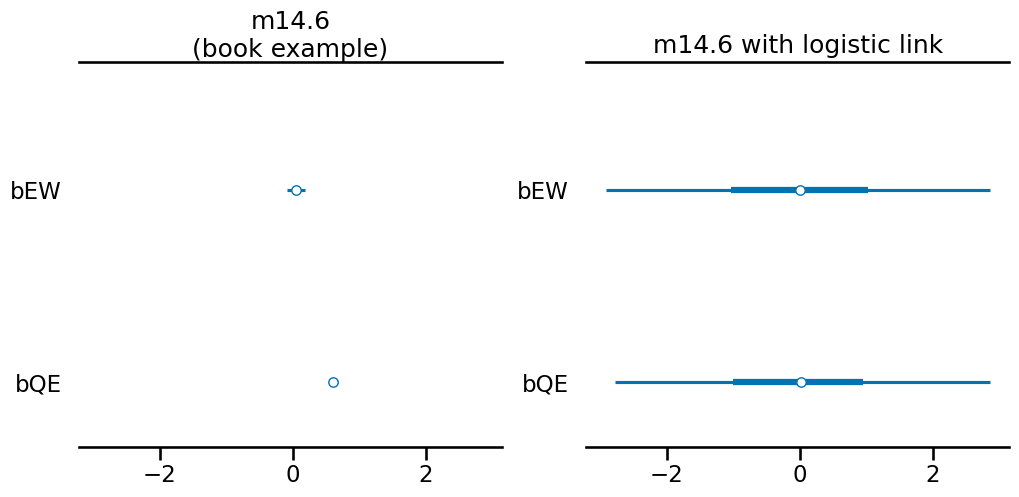

In [24]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5), sharex=True)
az.plot_forest(trace_14_6, var_names=['bEW', 'bQE'], combined=True, ax=ax0)
az.plot_forest(trace_14_6_logit, var_names=['bEW', 'bQE'], combined=True, ax=ax1)
ax0.set_title("m14.6\n(book example)")
ax1.set_title("m14.6 with logistic link")

### Visualize relationship of $W_i$ and R

In [25]:
# Get the W_i values which were assigned to vals[j, 0] in non-centered parameterization
df_trace_14_6_logit[df_trace_14_6_logit.index.str.contains('WE\[')].head()

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
/var/folders/xy/ddmp8rj12qbcmtfqxt7rhc6c0000gn/T/ipykernel_42093/933250025.py:2: SyntaxWarning: invalid escape sequence '\['
  df_trace_14_6_logit[df_trace_14_6_logit.index.str.contains('WE\[')].head()


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"WE[0, 0]",0.639,1.408,-1.290,3.540,0.091,0.064,347.0,448.0,1.03
"WE[0, 1]",-0.014,1.418,-2.371,2.979,0.025,0.018,3792.0,2650.0,1.00
"WE[1, 0]",0.620,1.376,-1.402,3.415,0.089,0.063,343.0,457.0,1.03
"WE[1, 1]",-0.000,1.412,-2.777,2.713,0.023,0.020,4305.0,2901.0,1.00
"WE[2, 0]",0.661,1.443,-1.255,3.839,0.090,0.064,417.0,342.0,1.03


In [26]:
df_trace_14_6_logit_W = df_trace_14_6_logit[df_trace_14_6_logit.index.str.contains('WE\[') & df_trace_14_6_logit.index.str.contains('0]')]
df_trace_14_6_logit_W.head()

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
/var/folders/xy/ddmp8rj12qbcmtfqxt7rhc6c0000gn/T/ipykernel_42093/4015736962.py:1: SyntaxWarning: invalid escape sequence '\['
  df_trace_14_6_logit_W = df_trace_14_6_logit[df_trace_14_6_logit.index.str.contains('WE\[') & df_trace_14_6_logit.index.str.contains('0]')]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"WE[0, 0]",0.639,1.408,-1.290,3.540,0.091,0.064,347.0,448.0,1.03
"WE[1, 0]",0.620,1.376,-1.402,3.415,0.089,0.063,343.0,457.0,1.03
"WE[2, 0]",0.661,1.443,-1.255,3.839,0.090,0.064,417.0,342.0,1.03
"WE[3, 0]",-0.646,1.464,-3.566,1.607,0.116,0.082,318.0,434.0,1.03
"WE[4, 0]",-0.640,1.410,-3.470,1.546,0.091,0.064,384.0,369.0,1.03


Text(0.5, 0, 'R\n(binary label)')

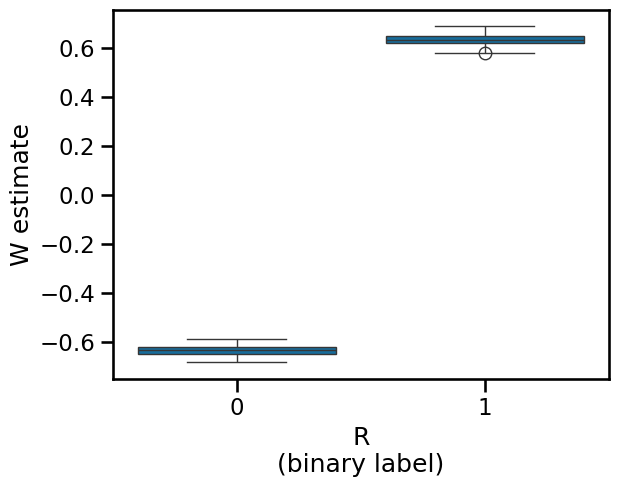

In [28]:
# merge and plot relationship of W_i with 
f, ax = plt.subplots()
sns.boxplot(data=df_trace_14_6_logit_W.reset_index().merge(dat_sim, left_index=True, right_index=True), x='R', y='mean', ax=ax)
ax.set_ylabel("W estimate")
ax.set_xlabel("R\n(binary label)")

I get the relationship I expect between $W$ and $R$.

# --- Everything below this can be ignored --- 

# My Mendelian randomization example

In [ ]:
# Set random seed for reproducibility
np.random.seed(19)

# coefficients
bUP = -1
bUD = 1
bGP = 1
bPD = 1

# Simulate data
n = 500
U_sim = np.random.normal(size=n)  # exogenous, unobserved confound
G_sim = np.random.choice(
    [0, 1, 2], size=n, p=[0.25, 0.5, 0.25]
)  # exogenous, genotype as denoted by number of alleles
P_sim = np.random.normal(
    loc = bUP * U_sim + bGP * G_sim
)  # generated by U and G, assume more alleles is positively associated with protein level
D_sim = np.random.normal(loc= bUD*U_sim + bUP*P_sim)  # generated by U and P levels

# Standardize or transform
G_standardized = standardize(G_sim.reshape(-1, 1)).flatten()
P_standardized = standardize(P_sim.reshape(-1, 1)).flatten()
D_binary = stats.bernoulli.rvs(
    expit(D_sim)
)  # transformed to 0/1 to represent disease state


df_data_sim = pd.DataFrame(
    {
        "G": G_standardized,
        "P": P_standardized,
        "D": D_binary,
    }
)

df_data_sim.head()

## Model 0, ignore confound, just look at impact of P

$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu_{P_i} $$
$$ \mu_{P_i} = \alpha + \beta_P P_i $$
$$ \alpha, \beta_P \sim \text{Normal}(0, 1.5) $$

In [ ]:
with pm.Model() as m0:

    # priors
    a = pm.Normal("a", 0, 1.5)
    bP = pm.Normal("bP", 0, 1.5)

    # link function
    p = pm.math.invlogit(a + bP * df_data_sim["P"])

    d = pm.Bernoulli("d", p=p, observed=df_data_sim["D"])

    trace_m0 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
    )

In [ ]:
az.summary(trace_m0)

Our estimate is closer to 2 than it is to 1.

## Model 1, add G as a predictor

$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu_{PG_i} $$
$$ \mu_{PG_i} = \alpha + \beta_P P_i + \beta_G G_i $$
$$ \alpha, \beta_P, \beta_G \sim \text{Normal}(0, 1.5) $$

In [ ]:
with pm.Model() as m1:

    # priors
    a = pm.Normal("a", 0, 1.5)
    bP = pm.Normal("bP", 0, 1.5)
    bG = pm.Normal("bG", 0, 1.5)

    # link function
    p = pm.math.invlogit(a + bP * df_data_sim["P"] + bG * df_data_sim["G"])

    d = pm.Bernoulli("d", p=p, observed=df_data_sim["D"])

    trace_m1 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
    )

In [ ]:
az.summary(trace_m1)

The estimate is even worse. This is an example of bias amplification.

## Model 2, MR

Model the joint error structure through mu.


$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = {D_{\text{cont,i}}} $$
$$ \left( \begin{array}{c} D_{\text{cont,i}} \\ {P_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{D_\text{cont,i}}}  \\ {\mu_{P_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{D_\text{cont,i}} = \alpha_D + \beta_P P_i  $$
$$ \mu_{P_i} = \alpha_P + \beta_G G_i  $$
$$ \alpha_D, \alpha_P \sim \text{Normal}(0, 1.5) $$
$$ \beta_P, \beta_G \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{P}^2 & \rho\sigma_{P}\sigma_{G} \\ 
                \rho\sigma_{P}\sigma_{G} & \sigma_{G}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{G} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$

In [ ]:
df_data_sim.head()

In [ ]:
df_data_sim['G'].value_counts()

In [ ]:
subj_index = df_data_sim.index.values

In [ ]:
df_data_sim.head()

In [ ]:
with pm.Model() as m2:
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    aD = pm.Normal("aD", mu=0, sigma=1.5)
    aP = pm.Normal("aP", mu=0, sigma=1.5)
    bPD = pm.Normal("bPD", mu=0, sigma=1.5)
    bGP = pm.Normal("bGP", mu=0, sigma=1.5)

    muD = aD + bPD * df_data_sim["P"]
    muP = aP + bGP * df_data_sim["G"]

    dp = pm.MvNormal("dp", mu=pt.stack([muD, muP]).T, chol=chol)

    # link function
    p = pm.math.invlogit(dp[subj_index, 0])

    d = pm.Bernoulli("d", p=p, observed=df_data_sim["D"])

    trace_m2 = pm.sample(1000, target_accept=0.9)

In [ ]:
az.summary(trace_m2, var_names=["bGP", "bPD", "chol_cov", "chol_cov_corr"])

# Check with statsmodels

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n = 1000

# Simulate genotype SNP (0, 1, 2) assuming Hardy-Weinberg equilibrium

genotype = np.random.choice([0, 1, 2], size=n, p=[0.25, 0.5, 0.25])
# Simulate protein intensity affected by genotype
# Assume beta_genotype is the effect size of genotype on protein intensity
beta_genotype = 0.5
protein_intensity = beta_genotype * genotype + np.random.normal(size=n)

# Simulate disease outcome affected by protein intensity
# Assume beta_protein is the effect size of protein intensity on disease
beta_protein = 1.0
disease = beta_protein * protein_intensity + np.random.normal(size=n)

# Create a DataFrame
data = pd.DataFrame(
    {"genotype": genotype, "protein_intensity": protein_intensity, "disease": disease}
)

data.head()

In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# First stage: Regress protein intensity on genotype
first_stage = sm.OLS(data["protein_intensity"], sm.add_constant(data["genotype"])).fit()

# Predicted protein intensity
data["protein_intensity_hat"] = first_stage.predict(sm.add_constant(data["genotype"]))

# Second stage: Regress disease on predicted protein intensity (instrumented)
second_stage = sm.OLS(
    data["disease"], sm.add_constant(data["protein_intensity_hat"])
).fit()

# Summary of the second stage regression
second_stage.summary()

# Check that coefficient using binomial GLM can be recovered from simulated data

In [ ]:
n = 200
a = np.random.normal(size=n)           # intercept at 0
bD = np.random.normal(loc=1, scale=0.2, size=n)   # bD coefficient at 1, make the spread narrow
X = np.random.normal(size=n)           # predictor variable
mu = a + bD*X
D_logit = stats.bernoulli.rvs(p=expit(mu))
df_data_sim_logit = pd.DataFrame(
    {'X':X,
     'mu':mu,
     'D':D_logit}
)

In [ ]:
df_data_sim_logit.head()

In [ ]:
sns.scatterplot(
    data=df_data_sim_logit,
    x='X',
    y='mu',
    hue='D'
)

$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu_i $$
$$ \mu_i = \alpha + \beta X_i $$
$$ \alpha \sim \text{Normal}(0,1.5) $$
$$ \beta \sim \text{Normal}(0,1.5) $$

In [ ]:
with pm.Model() as m_logit:

    # priors
    a = pm.Normal("a", mu=0, sigma=2)
    b = pm.Normal("b", mu=0, sigma=2)

    mu = a + b*df_data_sim_logit['X']

    # link function
    p = pm.math.invlogit(mu)

    d = pm.Bernoulli("d", p=p, observed=df_data_sim_logit["D"])

    trace_m_logit = pm.sample(1000, target_accept=0.9)

In [ ]:
az.summary(trace_m_logit)

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 06 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

seaborn   : 0.13.2
scipy     : 1.13.0
numpy     : 1.26.4
pytensor  : 2.20.0
arviz     : 0.18.0
pandas    : 2.2.2
matplotlib: 3.8.4
pymc      : 5.15.0

Watermark: 2.4.3

